<a href="https://colab.research.google.com/github/UW-CTRL/AA548-spr2024/blob/main/homework/hw2_problem4_starter_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [330]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp


## Open loop control with disturbance 

In [331]:
dt = 0.1
goal_state = np.zeros(4)
initial_state = np.array([-4, 0., -1., 2.])
u_max = 2.

### put your code here ###

A_dynamics = np.array([[1., 0., dt, 0.],
                        [0., 1., 0., dt],
                        [0., 0., 1., 0.],
                        [0., 0., 0., 1.]])

B_dynamics = np.array([[0.5*dt**2, 0.],
                        [0., 0.5*dt**2],
                        [dt, 0.],
                        [0.,  dt]])




Nmpc = 50  # time steps
n = 4   # state dimension
m = 2   # control dimension

us = cp.Variable([Nmpc,m])   # optimization variable.
xs = cp.Variable([Nmpc,n]) 

goal_state = np.zeros(n)
# quadratic cost matrices
Q = np.diag([1., 1., 1., 1.])
R = np.diag([1., 1.])


objective =  0
constraints = []


state = initial_state
constraints += [xs[0] == initial_state]
for t in range(Nmpc):
    objective += (cp.quad_form(state, Q) + cp.quad_form(us[t], R))
    state = A_dynamics @ state + B_dynamics @ us[t]
    constraints += [cp.norm(us[t], 2) <= u_max]

constraints += [state == goal_state]


problem = cp.Problem(cp.Minimize(objective), constraints)
problem.solve()


/home/p8410077/.local/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


604.1460607145349

In [332]:
## Generate disturbance 
sigma = np.array([0., 0., 0.1, 0.1])
wd = []
for i in range(50):
    wd.append(np.random.normal(0, sigma, size=(4)))

In [333]:
states = [initial_state]
for t in range(Nmpc):
    states.append(A_dynamics @ states[t] + B_dynamics @ us.value[t] + wd[t])
states = np.stack(states)

controls = us.value

## Plotting reults

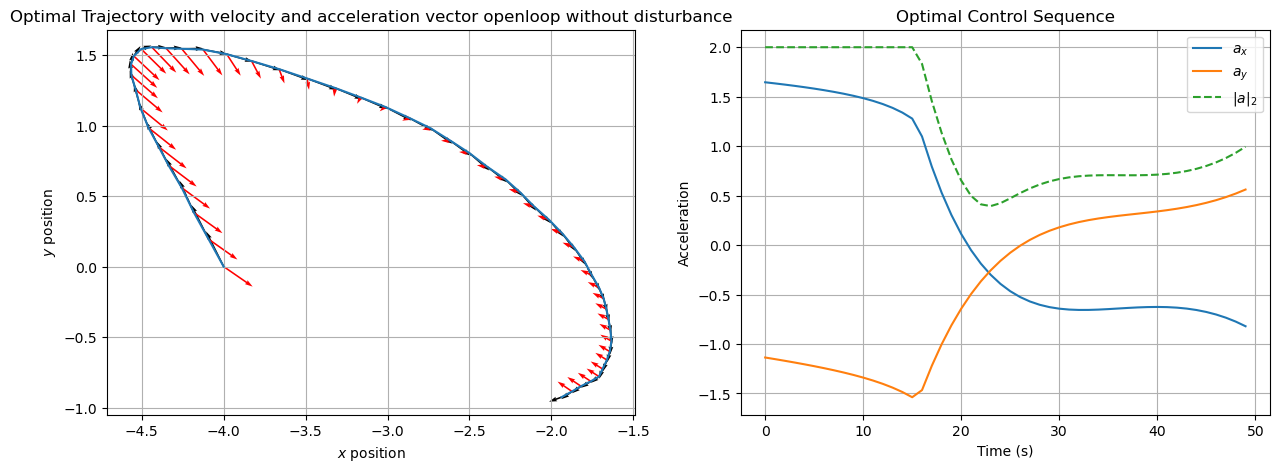

In [334]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(states[:,0], states[:,1])
plt.quiver(states[:,0], states[:,1], states[:,2], states[:,3], scale=30, width=.003)  # show velocity vector
plt.quiver(states[:-1,0], states[:-1,1], controls[:,0], controls[:,1], scale=30, width=.003, color='red')  # show acceleration vector
plt.title("Optimal Trajectory with velocity and acceleration vector openloop without disturbance")
plt.xlabel("$x$ position")
plt.ylabel("$y$ position")
plt.grid()

plt.subplot(1,2,2)
plt.plot(controls)
plt.plot(np.linalg.norm(controls, 2, axis=1), '--')
plt.title("Optimal Control Sequence")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration")
plt.legend(["$a_x$", "$a_y$", "$\|a\|_2$"])
plt.grid()

### plotting x and y, and computing which time step the state reaches within 10E-1 of goal state

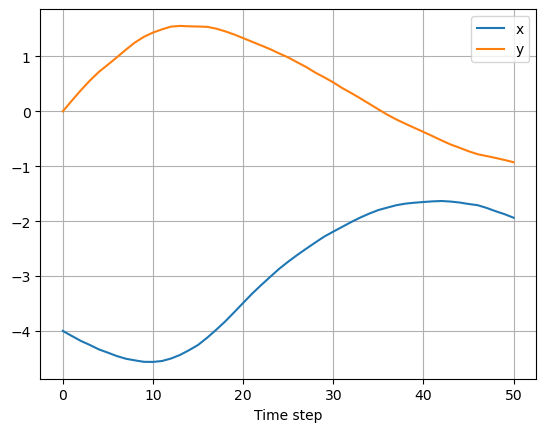

In [335]:
plt.plot(states[:,0], label="x")
plt.plot(states[:,1], label="y")
plt.xlabel("Time step")
plt.legend()
plt.grid()
#k_close = np.where(np.linalg.norm(states - goal_state, 2, axis=1) < 1E-1)[0][0]
#print("Time step when within 1E-1 to goal state: %i"%k_close)

In [336]:
def computetraject(currentstates, Qin, Rin, Qtin, finalstageflagin ): 
    dt = 0.1
    goal_state = np.zeros(4)
    initial_state = currentstates
    u_max = 2.

    ### put your code here ###

    A_dynamics = np.array([[1., 0., dt, 0.],
                            [0., 1., 0., dt],
                            [0., 0., 1., 0.],
                            [0., 0., 0., 1.]])

    B_dynamics = np.array([[0.5*dt**2, 0.],
                            [0., 0.5*dt**2],
                            [dt, 0.],
                            [0.,  dt]])




    Nmpc = 10  # time steps
    n = 4   # state dimension
    m = 2   # control dimension

    us = cp.Variable([Nmpc,m])   # optimization variable.
    xs = cp.Variable([Nmpc,n]) 

    goal_state = np.zeros(n)
    # quadratic cost matrices
    Q = Qin
    R = Rin
    Qt = Qtin

    objective =  0
    constraints = []


    state = initial_state
    constraints += [xs[0] == initial_state]
    for t in range(Nmpc):
        objective += (cp.quad_form(state, Q) + cp.quad_form(us[t], R))
        state = A_dynamics @ state + B_dynamics @ us[t]
        constraints += [cp.norm(us[t], 2) <= u_max]
        objective +=  cp.quad_form((goal_state-state), Qt)
        
    if finalstageflagin == 1:
        constraints += [state == goal_state]

    problem = cp.Problem(cp.Minimize(objective), constraints)
    problem.solve()
    return  xs, us

In [337]:
## MPC without disturbance 

k = 0
initstate =  np.array([-4, 0., -1., 2.])
currentstate = initstate
states2 = [initstate]
controls2 = []  
N = 50
Qout = np.diag([1., 1., 1., 1.])
Rout = np.diag([1., 1.])
Qtout = 10000*np.diag([5., 5., 1., 1.])
finalstageflag = 0
while k < N: 
    traject, us2 = computetraject(currentstate, Qout, Rout, Qtout, finalstageflag)
    states2.append(A_dynamics @ traject.value[0] + B_dynamics @ us2.value[0])
    controls2.append(us2.value[0])
    currentstate = A_dynamics @ traject.value[0] + B_dynamics @ us2.value[0]
    k = k+1

    if np.linalg.norm(currentstate - goal_state, 2) < 1:
        finalstageflag = 1

states2 = np.stack(states2)
controls2 = np.stack(controls2)

/home/p8410077/.local/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/home/p8410077/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


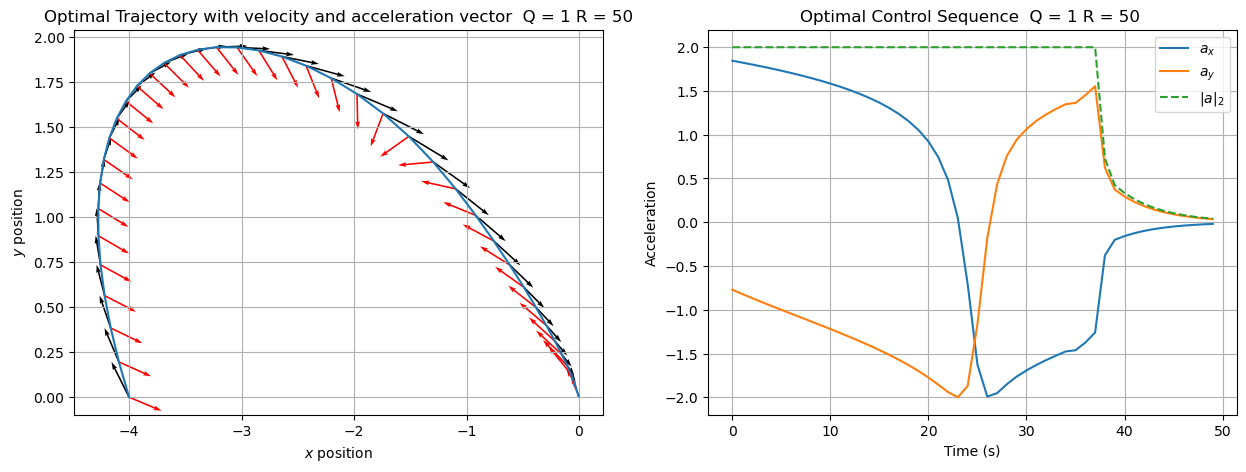

In [338]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(states2[:,0], states2[:,1])
plt.quiver(states2[:,0], states2[:,1], states2[:,2], states2[:,3], scale=30, width=.003)  # show velocity vector
plt.quiver(states2[:-1,0], states2[:-1,1], controls2[:,0], controls2[:,1], scale=30, width=.003, color='red')  # show acceleration vector
plt.title("Optimal Trajectory with velocity and acceleration vector  Q = 1 R = 50")
plt.xlabel("$x$ position")
plt.ylabel("$y$ position")
plt.grid()

plt.subplot(1,2,2)
plt.plot(controls2)
plt.plot(np.linalg.norm(controls2, 2, axis=1), '--')
plt.title("Optimal Control Sequence  Q = 1 R = 50 ")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration")
plt.legend(["$a_x$", "$a_y$", "$\|a\|_2$"])
plt.grid()

Time step when within 1E-1 to goal state: 43


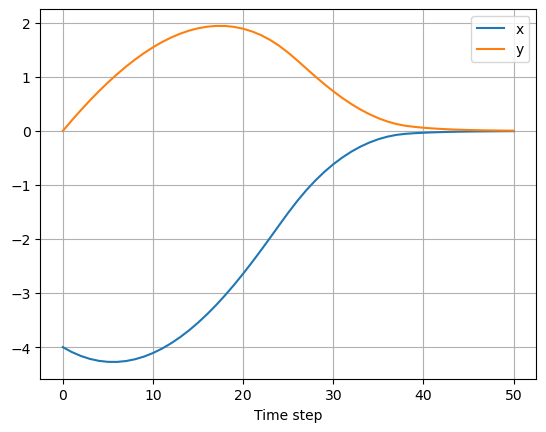

In [339]:
plt.plot(states2[:,0], label="x")
plt.plot(states2[:,1], label="y")
plt.xlabel("Time step")
plt.legend()
plt.grid()
k_close = np.where(np.linalg.norm(states2 - goal_state, 2, axis=1) < 1E-1)[0][0]
print("Time step when within 1E-1 to goal state: %i"%k_close)

In [344]:
k = 0
initstate3 =  np.array([-4, 0., -1., 2.])
currentstate3 = initstate3
states3 = [initstate3]
controls3 = []  
N = 50
Qout = np.diag([1., 1., 1., 1.])
Rout = np.diag([1., 1.])
Qtout = 10000*np.diag([5., 5., 1., 1.])
finalstageflag = 0
while k < N: 
    #sigma = np.array([0., 0., 0.1, 0.1])
    #wd = np.random.normal(0, sigma, size=(4))
    traject3, us3 = computetraject(currentstate3, Qout, Rout, Qtout, finalstageflag)
    a = A_dynamics @ traject3.value[0]
    b = B_dynamics @ us3.value[0]
    c = a + b 
    statenext3 = c + wd[k]
    states3.append(statenext3)
    controls3.append(us3.value[0])
    currentstate3 = statenext3
    k = k+1
    if np.linalg.norm(currentstate3 - goal_state, 2) < 0.5:
        finalstageflag = 1

states3 = np.stack(states3)
controls3 = np.stack(controls3)

/home/p8410077/.local/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/home/p8410077/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


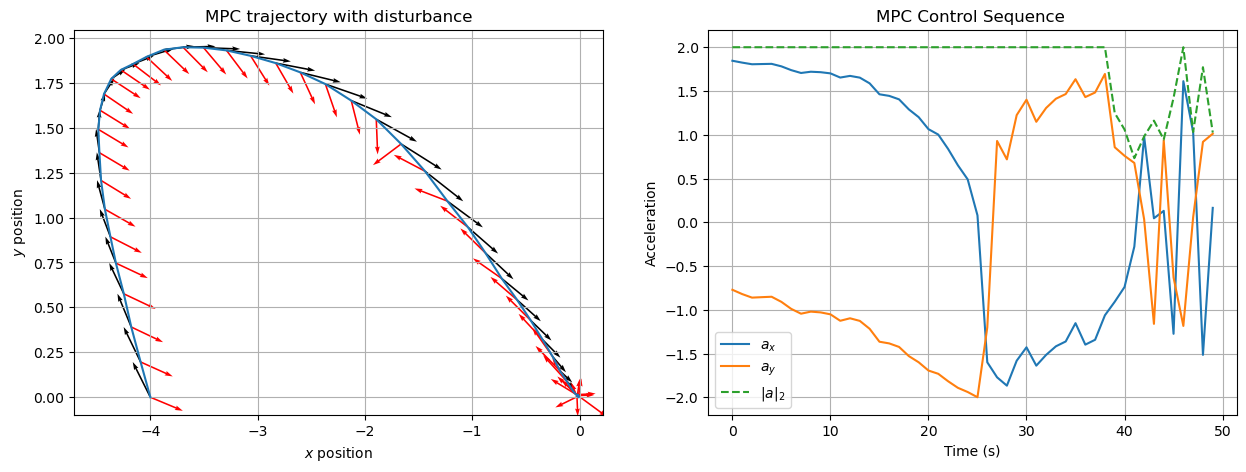

In [348]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(states3[:,0], states3[:,1])
plt.quiver(states3[:,0], states3[:,1], states3[:,2], states3[:,3], scale=30, width=.003)  # show velocity vector
plt.quiver(states3[:-1,0], states3[:-1,1], controls3[:,0], controls3[:,1], scale=30, width=.003, color='red')  # show acceleration vector
plt.title("MPC trajectory with disturbance")
plt.xlabel("$x$ position")
plt.ylabel("$y$ position")
plt.grid()

plt.subplot(1,2,2)
plt.plot(controls3)
plt.plot(np.linalg.norm(controls3, 2, axis=1), '--')
plt.title("MPC Control Sequence ")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration")
plt.legend(["$a_x$", "$a_y$", "$\|a\|_2$"])
plt.grid()

Time step when within 1E-1 to goal state: 42


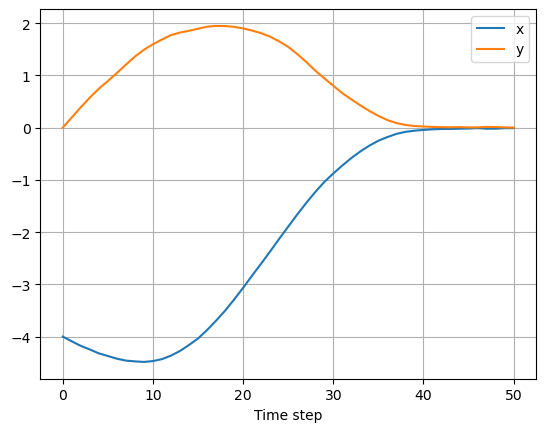

In [349]:
plt.plot(states3[:,0], label="x")
plt.plot(states3[:,1], label="y")
plt.xlabel("Time step")
plt.legend()
plt.grid()
k_close = np.where(np.linalg.norm(states3 - goal_state, 2, axis=1) < 1E-1)[0][0]
print("Time step when within 1E-1 to goal state: %i"%k_close)

NameError: name 'states4' is not defined

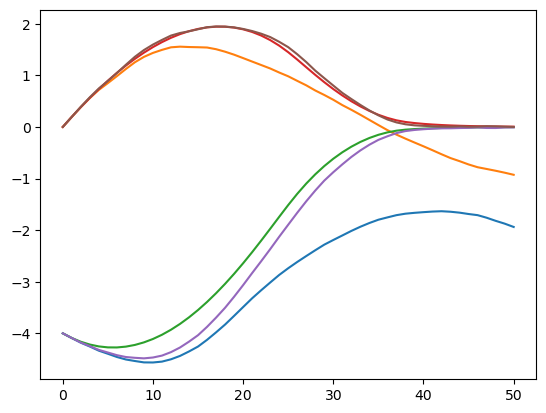

In [343]:
plt.plot(states[:,0], label="x")
plt.plot(states[:,1], label="y")
plt.plot(states2[:,0], label="x = Q=50 R=1")
plt.plot(states2[:,1], label="y = Q=50 R=1")
plt.plot(states3[:,0], label="x = Q=1 R=50")
plt.plot(states3[:,1], label="y = Q=1 R=50")
plt.plot(states4[:,0], label="x = Q=50 R=1 umax = 20")
plt.plot(states4[:,1], label="y = Q=00 R=1 umax = 20")
plt.plot(states5[:,0], label="x = Q=[1, 1, 0, 0] R=0 umax = 2")
plt.plot(states5[:,1], label="y = Q=[1, 1, 0, 0] R=0 umax = 2")
plt.xlabel("Time step")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.grid()
k_close = np.where(np.linalg.norm(states - goal_state, 2, axis=1) < 1E-1)[0][0]
print("Time step when within 1E-1 to goal state: %i"%k_close)

k_close = np.where(np.linalg.norm(states2 - goal_state, 2, axis=1) < 1E-1)[0][0]
print("Time step when within 1E-1 to goal state: %i"%k_close)

k_close = np.where(np.linalg.norm(states3 - goal_state, 2, axis=1) < 1E-1)[0][0]
print("Time step when within 1E-1 to goal state: %i"%k_close)

k_close = np.where(np.linalg.norm(states4 - goal_state, 2, axis=1) < 1E-1)[0][0]
print("Case: Q=50 R=1 umax = 20 Time step when within 1E-1 to goal state: %i"%k_close)

k_close = np.where(np.linalg.norm(states5 - goal_state, 2, axis=1) < 1E-1)[0][0]
print("Case: Q=[1, 1, 0, 0] R=0 umax = 2 Time step when within 1E-1 to goal state: %i"%k_close)